In [306]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_4'

In [307]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [308]:
col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(f'{dir}/housing.csv', delimiter='\s+', names=col_names)

In [309]:
from sklearn.model_selection import train_test_split

X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354,), (152,))

In [310]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay

common_params = {
    'X': X,
    'y': y,
    'train_sizes': np.linspace(0.1, 1.0, 10),
    'cv': ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    'score_type': 'both',
    'n_jobs': 4,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
    'score_name': 'R^2 Score',
    'random_state': 123,
}

# Линейная регрессия

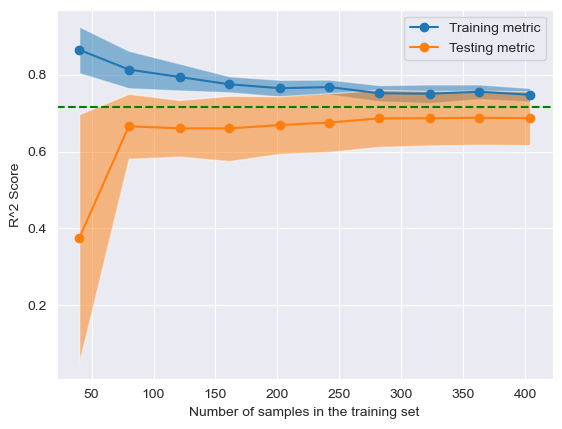

In [311]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X_train, y_train)
LearningCurveDisplay.from_estimator(model1, **common_params)
target_accuracy_estimate = 0.715  # примерно к этому показателю стремятся кривые при n --> inf
plt.axhline(target_accuracy_estimate, c='green', linestyle='dashed')

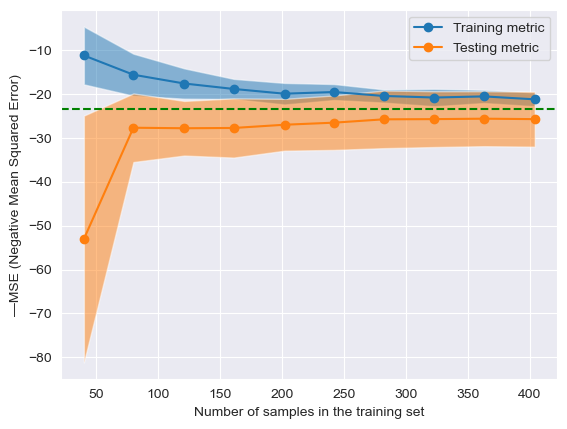

In [312]:
from skimage.metrics import mean_squared_error
from sklearn.metrics import make_scorer

mse_params = common_params.copy()
mse_params['score_name'] = '—MSE (Negative Mean Squared Error)'
mse_params['scoring'] = make_scorer(mean_squared_error, greater_is_better=False)
LearningCurveDisplay.from_estimator(model1, **mse_params)
target_accuracy_estimate = -23.5  # примерно к этому показателю стремятся кривые при n --> inf
plt.axhline(target_accuracy_estimate, c='green', linestyle='dashed')

# Дерево решений

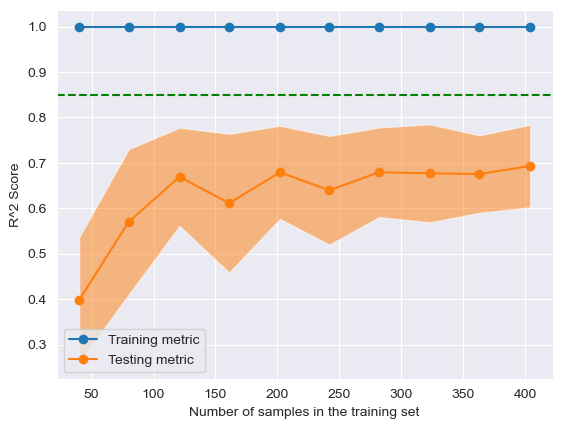

In [313]:
from sklearn.tree import DecisionTreeRegressor

model2 = DecisionTreeRegressor()
model2.fit(X_train, y_train)
LearningCurveDisplay.from_estimator(model2, **common_params)
target_accuracy_estimate = 0.85  # примерно к этому показателю стремятся кривые при n --> inf
plt.axhline(target_accuracy_estimate, c='green', linestyle='dashed')

# Вывод

Для предложенного датасета лучше подходит **линейная регрессия**, по крайней мере при стандартных значениях гиперпараметров. Дерево решений же подвергается **переобучению**. Это видно из последнего графика, на котором кривые `Training metric` и `Testing metric` сходятся крайне плохо. Кроме того, видно, что на обучающей выборке метрика R^2 всегда почти единица, т.е. модель справляется на обучающих данных идеально, в то время как на тестовых данных она даёт большую ошибку и едва ли "побеждает" наивную модель, которая бы всегда предсказывала среднее значение.

# Сравнение трёх линейных моделей. Регуляризация

In [314]:
from sklearn.metrics import r2_score, mean_squared_error

In [315]:
features = col_names.copy()
features.remove('MEDV')
c_weights = pd.DataFrame(columns=features)

scores = ['r2', 'mse']
c_scores = pd.DataFrame(columns=scores)

In [316]:
def experiment(c_name, c_model):
    global c_weights, c_scores

    c_model.fit(X_train, y_train)
    y_pred = c_model.predict(X_test)
    
    c_model_weights = pd.DataFrame(abs(c_model.coef_).reshape(1, -1), index=[c_name], columns=features)
    c_weights = pd.concat([c_weights, c_model_weights])
    c_model_scores = pd.DataFrame(np.asarray([
        r2_score(y_test, y_pred),
        mean_squared_error(y_test, y_pred)
    ]).reshape(1, -1), index=[c_name], columns=scores)
    c_scores = pd.concat([c_scores, c_model_scores])

In [317]:
from sklearn.linear_model import LinearRegression
experiment('No Regularization', LinearRegression())

In [318]:
from sklearn.linear_model import RidgeCV
experiment('L2 Regularization (RidgeCV)', RidgeCV())

In [319]:
from sklearn.linear_model import LassoCV
experiment('L1 Regularization (LassoCV)', LassoCV())

In [320]:
from sklearn.linear_model import ElasticNetCV
experiment('L2+L1 Regularization (ElasticNetCV)', ElasticNetCV())

In [321]:
c_scores

,r2,mse
No Regularization,0.648565,28.405855
L2 Regularization (RidgeCV),0.647136,28.521324
L1 Regularization (LassoCV),0.643555,28.810752
L2+L1 Regularization (ElasticNetCV),0.631715,29.767814


<Axes: >

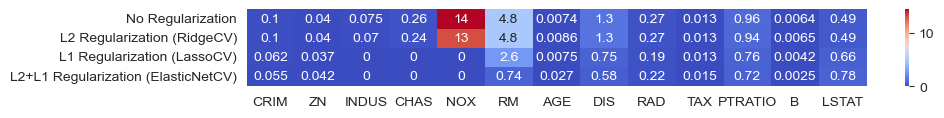

In [322]:
import seaborn as sns

plt.figure(figsize=(10, 1))
sns.heatmap(c_weights, annot=True, cmap='coolwarm')

### Выводы (сравнение)

Признаки, оказавшиеся важными во всех трёх линейных моделях: `RM`, `DIS`, `PTRATIO` и `LSTAT`. Итоговые веса у модели без регуляризации и у модели с L2-регуляризацией в целом очень похожи, как и их точность (почти не отличается по обеим рассмотренным метрикам: R^2 и MSE). А вот модель с L1-регуляризацией имеет гораздо более маленькие (по абсолютной величине) веса для всех признаков. Более того, некоторые признаки она и вовсе обнулила. Что интересно, был обнулён признак `NOX`, который, наоборот, имел самый высокий вес в двух предыдущих моделях. Разрыв в качестве между `Ridge` и `Lasso` моделями чуть выше, чем между `Lasso` и `No Regularization`, но в целом всё равно низкий. С `ElasticNet` моделью, совмещающей L1- и L2-регуляризации, ситуация похожая: все веса очень малы по абсолютной величине, а вот качество по сравнению с предыдущими тремя моделями ухудшилось уже заметнее. Тем не менее, в целом в данном случае все 4 рассмотренные модели показали схожие результаты. Лучший оказался у модели без регуляризации.